![alt text](header.png)

# 📚 Importación de librerías

In [3]:
# Librerías para procesamiento de datos
import os
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta, date

# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Librerías machine learning
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest

from scipy.stats import chi2_contingency
from scipy.stats import chisquare

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

In [4]:
# Importación de los datos
df = pd.read_csv('./datos/df.csv', dtype={
    'es_fraude':'Int64',
    'tipo':'string',
    'mensaje_alarma':'string',
    'origen':'string',
    'destino':'string'
    })

# 📲 Preprocesado de datos

In [5]:
print('Estructura y tipo de datos:\n')
print('*+' * 15, '\n')
print(df.columns, '\n')
print('*+' * 15, '\n')
print(df.dtypes)

Estructura y tipo de datos:

*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+ 

Index(['t_id', 'origen', 'destino', 'cuantia', 'es_fraude', 'mensaje_alarma',
       'hora_transaccion', 'tipo', 'balance_prev_or', 'balance_post_or',
       'balance_prev_des', 'balance_post_des'],
      dtype='object') 

*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+ 

t_id                         int64
origen              string[python]
destino             string[python]
cuantia                    float64
es_fraude                    Int64
mensaje_alarma      string[python]
hora_transaccion            object
tipo                string[python]
balance_prev_or            float64
balance_post_or            float64
balance_prev_des           float64
balance_post_des           float64
dtype: object


In [6]:
print('Estadísticas del dataset:\n')
print('*+' * 15, '\n')
display(df.describe())

Estadísticas del dataset:

*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+ 



,t_id,cuantia,es_fraude,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des
count,6.362520e+06,6.362520e+06,6362520.0,6.362520e+06,6.362520e+06,6.362520e+06,6.362520e+06
mean,3.181312e+06,1.798620e+05,0.00129,8.338892e+05,8.551206e+05,1.100707e+06,1.225002e+06
std,1.836730e+06,6.038617e+05,0.035896,2.888257e+06,2.924063e+06,3.399201e+06,3.674152e+06
min,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.590656e+06,1.338957e+04,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.181316e+06,7.487271e+04,0.0,1.420800e+04,0.000000e+00,1.327077e+05,2.146622e+05
75%,4.771964e+06,2.087216e+05,0.0,1.073150e+05,1.442585e+05,9.430375e+05,1.111909e+06
max,6.362619e+06,9.244552e+07,1.0,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


## 🫧 Feature Cleaning y Feature Engineering

In [22]:
df[df['es_fraude'] == 1]['tipo'].value_counts()

tipo
CASH_OUT    4114
TRANSFER    4095
Name: count, dtype: Int64

### Manejo de valores nulos

Los valores nulos en un dataset importan:

*   Ciertos algoritmos no funcionan cuando hay valores nulos presentes.  
*   Incluso para algoritmos que soportan valores nulos, sin el tratamiento de los mismos, el modelo puede conducir a conclusiones imprecisas.

In [7]:
# Comprobación para ver si el dataset contiene algún valor NULL
df.isnull().any()

t_id                False
origen              False
destino             False
cuantia             False
es_fraude           False
mensaje_alarma      False
hora_transaccion    False
tipo                False
balance_prev_or     False
balance_post_or     False
balance_prev_des    False
balance_post_des    False
dtype: bool

### Distribución de variables

#### Variable: tipo

In [53]:
# Gráfico para visualizar la distribución del tipo de transacciones
counts = df['tipo'].value_counts().reset_index()
counts.columns = ['tipo', 'frecuencia']
color_palette = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

fig = px.bar(
    counts,
    x='frecuencia',
    y='tipo',
    orientation='h',
    color='tipo',
    color_discrete_sequence=color_palette,
    title='Distribución de Tipos de Transacción (Horizontal)',
    labels={
        'tipo': 'Tipo de Transacción',
        'frecuencia': 'Número de Transacciones'
    }
)

fig.update_layout(
    width=800,     # Ajustar ancho
    height=600,    # Ajustar alto
    bargap=0.2     # Espacio entre barras
)

fig.show()

Las transacciones más frecuentes en el dataset son las de tipo CASH_OUT y PAYMENT.

In [59]:
print(f'· Conteo de transacciones totales: {df.count()[0]} siendo fraudulentas (es_fraude = 1) {df['es_fraude'].value_counts()[1]} transacciones.\n')
print(f'· Desbalanceo de clases: El {((df['es_fraude'].value_counts()[1]/df.count()[0])*100).round(3)}% de las transacciones son positivas respecto del total de transacciones\n')
print(f'· Target: es_fraude, 1 para fraude, 0 para el resto de casos.')

· Conteo de transacciones totales: 6362520 siendo fraudulentas (es_fraude = 1) 8209 transacciones.

· Desbalanceo de clases: El 0.129% de las transacciones son positivas respecto del total de transacciones

· Target: es_fraude, 1 para fraude, 0 para el resto de casos.


Las clases se encuentran muy desbalanceadas, apenas el 0.13€ de las instancias se clasifican como fraudulentas. Más adelante se trarará este desbalanceo de clases.

#### Variable: es_fraude

In [60]:
# Gráfico para visualizar la distribución del tipo de transacción fraudulenta
counts = df[df['es_fraude'] == 1]['tipo'].value_counts().reset_index()
counts.columns = ['tipo', 'frecuencia']
color_palette = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

fig = px.bar(
    counts,
    x='tipo',
    y='frecuencia',
    color='tipo',
    color_discrete_sequence=color_palette,
    title='Distribución de Tipos de Transacción Fraudulenta',
    labels={
        'tipo': 'Tipo de Transacción',
        'frecuencia': 'Número de Transacciones'
    }
)

fig.update_layout(
    width=600,     # Ajustar ancho
    height=600,    # Ajustar alto
    bargap=0.2     # Espacio entre barras
)

fig.show()

Este gráfico revela que las transacciones fraudulentas solo ocurren para el tipo de transacción CASH_OUT (retiradas de efectivo) y TRANSFER (transferencias bancarias).

#### Variable: cuantia

A continuación, veremos cuál es la distribución de la variable cuantía para las transacciones fraudulentas.

<Axes: xlabel='es_fraude', ylabel='cuantia'>

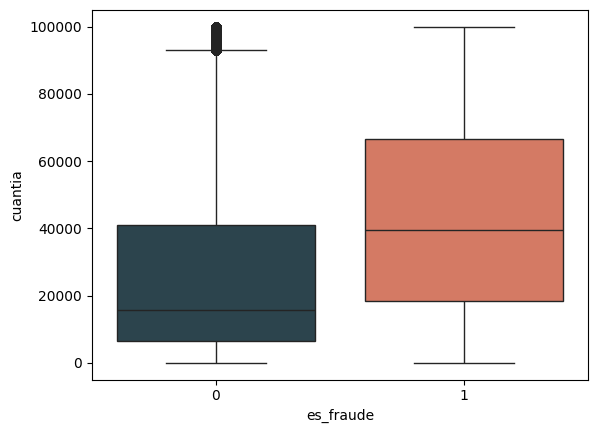

In [79]:
sns.boxplot(x='es_fraude', y='cuantia', data=df[df.cuantia < 1e5], palette={'0': '#264653', '1': '#e76f51'})

En el diagrama de cajas y bigotes se aprecia que las transacciones fraudulentas tienden a ocurrir con cantidades más altas respecto a las no fraudulentas.

#### Variable: mensaje_alarma

In [8]:
df['mensaje_alarma'].value_counts()

mensaje_alarma
No_detectado_fraude    6362504
Detectado_fraude            16
Name: count, dtype: Int64

In [9]:
# Cambiamos la cadena de texto por 0 y 1
df['mensaje_alarma'] = np.where(df['mensaje_alarma'] == 'No_detectado_fraude', 0, 1)

In [10]:
df.head(5)

,t_id,origen,destino,cuantia,es_fraude,mensaje_alarma,hora_transaccion,tipo,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des
0,0,C1231006815,M1979787155,9839.64,0,0,2022-09-01 08:00:00,PAYMENT,170136.0,160296.36,0.0,0.0
1,1,C1666544295,M2044282225,1864.28,0,0,2022-09-01 08:00:00,PAYMENT,21249.0,19384.72,0.0,0.0
2,2,C1305486145,C553264065,181.00,1,0,2022-09-01 08:00:00,TRANSFER,181.0,0.00,0.0,0.0
3,3,C840083671,C38997010,181.00,1,0,2022-09-01 08:00:00,CASH_OUT,181.0,0.00,21182.0,0.0
4,4,C2048537720,M1230701703,11668.14,0,0,2022-09-01 08:00:00,PAYMENT,41554.0,29885.86,0.0,0.0


In [83]:
df[(df['mensaje_alarma'] == 1)]

,t_id,origen,destino,cuantia,es_fraude,mensaje_alarma,hora_transaccion,tipo,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des
2736399,2736446,C728984460,C639921569,4953893.08,1,1,2022-09-10 03:00:00,TRANSFER,4953893.08,4953893.08,0.0,0.0
3247240,3247297,C1100582606,C1147517658,1343002.08,1,1,2022-09-11 17:00:00,TRANSFER,1343002.08,1343002.08,0.0,0.0
3760224,3760288,C1035541766,C1100697970,536624.41,1,1,2022-09-12 22:00:00,TRANSFER,536624.41,536624.41,0.0,0.0
5563622,5563713,C908544136,C891140444,4892193.09,1,1,2022-09-17 10:00:00,TRANSFER,4892193.09,4892193.09,0.0,0.0
5996313,5996407,C689608084,C1392803603,10000000.00,1,1,2022-09-19 00:00:00,TRANSFER,19585040.37,19585040.37,0.0,0.0
5996315,5996409,C452586515,C1109166882,9585040.37,1,1,2022-09-19 00:00:00,TRANSFER,19585040.37,19585040.37,0.0,0.0
6168403,6168499,C193696150,C484597480,3576297.10,1,1,2022-09-24 09:00:00,TRANSFER,3576297.10,3576297.10,0.0,0.0
6205342,6205439,C1684585475,C1770418982,353874.22,1,1,2022-09-25 17:00:00,TRANSFER,353874.22,353874.22,0.0,0.0
6266315,6266413,C786455622,C661958277,2542664.27,1,1,2022-09-27 00:00:00,TRANSFER,2542664.27,2542664.27,0.0,0.0
6281382,6281482,C19004745,C1806199534,10000000.00,1,1,2022-09-28 05:00:00,TRANSFER,10399045.08,10399045.08,0.0,0.0


De los 16 registros en los que han saltado la alarma, se observa lo siguiente:

* El tipo de transacción siempre es de tipo TRANSFER.
* Todas las instancias tienen el balance_prev_des y balance_post_des iguales e iguales a 0, es decir, no se descuenta el valor del dinero en la transacción.
* Parece que cuando hay un intento de transferencia de elevada cuantía, el sistema marca esa transacción como fraudulenta.

#### Variable: balance_prev_des y balance_post_des

#### Variable: balance_prev_or y balance_post_or

#### Variable: hora_transaccion

In [219]:
df.head()

,t_id,origen,destino,cuantia,es_fraude,mensaje_alarma,hora_transaccion,tipo,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des
0,0,C1231006815,M1979787155,9839.64,0,No_detectado_fraude,2022-09-01 08:00:00,PAYMENT,170136.0,160296.36,0.0,0.0
1,1,C1666544295,M2044282225,1864.28,0,No_detectado_fraude,2022-09-01 08:00:00,PAYMENT,21249.0,19384.72,0.0,0.0
2,2,C1305486145,C553264065,181.00,1,No_detectado_fraude,2022-09-01 08:00:00,TRANSFER,181.0,0.00,0.0,0.0
3,3,C840083671,C38997010,181.00,1,No_detectado_fraude,2022-09-01 08:00:00,CASH_OUT,181.0,0.00,21182.0,0.0
4,4,C2048537720,M1230701703,11668.14,0,No_detectado_fraude,2022-09-01 08:00:00,PAYMENT,41554.0,29885.86,0.0,0.0


In [11]:
df_tiempo_original = pd.read_csv('./datos/tiempo_original.csv')
df = pd.merge(df_tiempo_original, df, on="t_id", how="inner")
df.drop('hora_transaccion_y', axis=1, inplace=True)
df.rename(columns={'hora_transaccion_x':'hora_transaccion'}, inplace=True)

In [12]:
df.head()

,hora_transaccion,t_id,origen,destino,cuantia,es_fraude,mensaje_alarma,tipo,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des
0,1,0,C1231006815,M1979787155,9839.64,0,0,PAYMENT,170136.0,160296.36,0.0,0.0
1,1,1,C1666544295,M2044282225,1864.28,0,0,PAYMENT,21249.0,19384.72,0.0,0.0
2,1,2,C1305486145,C553264065,181.00,1,0,TRANSFER,181.0,0.00,0.0,0.0
3,1,3,C840083671,C38997010,181.00,1,0,CASH_OUT,181.0,0.00,21182.0,0.0
4,1,4,C2048537720,M1230701703,11668.14,0,0,PAYMENT,41554.0,29885.86,0.0,0.0


In [13]:
df.isnull().any()

hora_transaccion    False
t_id                False
origen              False
destino             False
cuantia             False
es_fraude           False
mensaje_alarma      False
tipo                False
balance_prev_or     False
balance_post_or     False
balance_prev_des    False
balance_post_des    False
dtype: bool

### Feature Encoding

Debemos transformar las cadenas de variables categóricas en números para que los algoritmos puedan manejar esos valores. Incluso aunque pueda suceder que un algoritmo pueda aceptar entradas categóricas, es muy probable que el algoritmo incorpore el proceso de codificación internamente.

#### One hot encoding

In [14]:
print(df['tipo'].unique())

<StringArray>
['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']
Length: 5, dtype: string


In [16]:
from sklearn.preprocessing import OneHotEncoder

# Inicializamos el codificador
encoder = OneHotEncoder(sparse_output=False)

# Ajustamos y transformamos la columna 'tipo'
encoded_data = encoder.fit_transform(df[['tipo']])

# Definimos correctamente los nombres de columnas (faltaba este paso)
column_names = encoder.get_feature_names_out(['tipo'])
column_names = [col.replace('tipo_', '') for col in column_names]

# Creamos el DataFrame codificado manteniendo el índice original
encoded_df = pd.DataFrame(encoded_data, columns=column_names, index=df.index).astype(int)

# Eliminamos columnas originales innecesarias y unimos con las nuevas codificadas
df = pd.concat([df.drop(columns=['tipo', 'origen', 'destino']), encoded_df], axis=1)

display(df.head())

,hora_transaccion,t_id,cuantia,es_fraude,mensaje_alarma,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0,9839.64,0,0,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1,1864.28,0,0,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,2,181.00,1,0,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,3,181.00,1,0,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,1,4,11668.14,0,0,41554.0,29885.86,0.0,0.0,0,0,0,1,0


### Feature Selection

La selección de características es el proceso de elegir un subconjunto de características relevantes para su uso en la construcción de modelos de aprendizaje automático.

No siempre es cierto que cuanta más información tengamos, mejor será el resultado. Incluir características irrelevantes (aquellas que no aportan valor a la predicción) y características redundantes (irrelevantes en presencia de otras) solo sobrecargará el proceso de aprendizaje y aumentará el riesgo de sobreajuste (overfitting).

Con la selección de características, podemos lograr:

* Simplificación de modelos, facilitando su interpretación.
* Tiempos de entrenamiento más cortos y menor costo computacional.
* Menor costo en la recopilación de datos.
* Evitar la maldición de la dimensionalidad.
* Mejor generalización al reducir el sobreajuste.
* Es importante recordar que diferentes subconjuntos de características pueden ofrecer un rendimiento óptimo para distintos algoritmos. Por lo tanto, la selección de características no es un proceso separado del entrenamiento del modelo de aprendizaje automático.

Si estamos seleccionando características para un modelo lineal, es mejor utilizar procedimientos de selección específicos para este tipo de modelos, como la importancia basada en coeficientes de regresión o Lasso. Por otro lado, si estamos seleccionando características para modelos basados en árboles, es preferible utilizar la importancia derivada de los árboles.

#### Análisis de redundancia (RDA)

##### De atributos:

A continuación, se va a comprobar la redundancia de las características mediante el análisis de correlación, ya que todas las variables son numéricas.

In [275]:
df.columns

Index(['hora_transaccion', 't_id', 'cuantia', 'es_fraude', 'mensaje_alarma',
       'balance_prev_or', 'balance_post_or', 'balance_prev_des',
       'balance_post_des', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER'],
      dtype='object')

In [58]:
variables_cuantitativas = df.iloc[:, [0, 3, 4, 5, 6, 7]]
variables_cuantitativas.columns

Index(['hora_transaccion', 'es_fraude', 'mensaje_alarma', 'balance_prev_or',
       'balance_post_or', 'balance_prev_des'],
      dtype='object')

In [59]:
corr_matrix = variables_cuantitativas.corr(method='pearson')
corr_matrix.style.background_gradient(cmap='PuOr')


,hora_transaccion,es_fraude,mensaje_alarma,balance_prev_or,balance_post_or,balance_prev_des
hora_transaccion,1.000000,0.031555,0.003277,-0.010058,-0.010298,0.027666
es_fraude,0.031555,1.000000,0.044120,0.010157,-0.008145,-0.005881
mensaje_alarma,0.003277,0.044120,1.000000,0.003835,0.003776,-0.000514
balance_prev_or,-0.010058,0.010157,0.003835,1.000000,0.998803,0.066243
balance_post_or,-0.010298,-0.008145,0.003776,0.998803,1.000000,0.067812
balance_prev_des,0.027666,-0.005881,-0.000514,0.066243,0.067812,1.000000


In [277]:
fig = px.imshow(corr_matrix, text_auto=True, aspect='auto', title='Matriz de Correlación')
fig.show()

Se nota una fuerte correlación entre las siguientes variables:

* oldbalanceDest y newbalanceDest
* oldbalanceOrg y newbalanceOrig

Esta relación se debe a la influencia mutua entre las variables. Por ejemplo, cuando se realiza una transferencia de dinero a un destinatario, el saldo de destino aumenta mientras que el saldo de origen disminuye.

Por ahora, no se eliminan estas variables ya que no se encuentran correlacionadas de manera significativa con otras variables.

Además, más adelante se explorarán otros métodos, como el PCA, que ayudan a seleccionar las variables que deben eliminarse para reducir la dimensionalidad del conjunto de datos.

##### De registros:

El test Chi-cuadrado (Chi-Square) se utiliza para evaluar si existe una dependencia estadísticamente significativa entre variables categóricas. Ayuda a seleccionar solo aquellas características categóricas que tienen relación significativa con la variable objetivo (en este caso, la variable que indica fraude o no)

In [278]:
df.head()

,hora_transaccion,t_id,cuantia,es_fraude,mensaje_alarma,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,0,9839.64,0,No_detectado_fraude,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1,1864.28,0,No_detectado_fraude,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,2,181.00,1,No_detectado_fraude,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,3,181.00,1,No_detectado_fraude,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,1,4,11668.14,0,No_detectado_fraude,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [17]:
df.isnull().values.any()

np.False_

In [18]:
from sklearn.feature_selection import chi2

# Separar las variables predictoras (ya codificadas) y la variable objetivo
X = df.drop('es_fraude', axis=1)
y = df['es_fraude']

# Aplicar el test chi-cuadrado para cada característica
chi2_stats, p_values = chi2(X, y)

# Crear un DataFrame para visualizar los resultados
resultados = pd.DataFrame({
    'Variable': X.columns,
    'Chi2': chi2_stats,
    'p-value': p_values
})

display(resultados)


,Variable,Chi2,p-value
0,hora_transaccion,5.272793e+05,0.000000e+00
1,t_id,2.920313e+09,0.000000e+00
2,cuantia,7.586027e+10,0.000000e+00
3,mensaje_alarma,1.238506e+04,0.000000e+00
4,balance_prev_or,6.565946e+09,0.000000e+00
5,balance_post_or,4.220572e+09,0.000000e+00
6,balance_prev_des,2.310118e+09,0.000000e+00
7,balance_post_des,2.041072e+07,0.000000e+00
8,CASH_IN,1.807687e+03,0.000000e+00
9,CASH_OUT,5.223640e+02,1.294894e-115


In [19]:
df[df['es_fraude'] == 1][['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']].value_counts()

CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER
0        1         0      0        0           4114
         0         0      0        1           4095
Name: count, dtype: int64

* Cuantía y balance previo de origen son extremadamente predictivos para fraudes.
* TRANSFER, mensaje_alarma y CASH_OUT también son importantes para la detección de fraude.

##### Análisis de duplicados:

Se verifica que no existan registros duplicados en el conjunto de datos.

Para ello, se utiliza la función duplicated() de pandas, que detecta filas idénticas en el dataset, marcando como duplicadas todas las apariciones después de la primera instancia encontrada.

In [20]:
df.duplicated().any()

np.False_

In [285]:
df[df.duplicated()]

,hora_transaccion,t_id,cuantia,es_fraude,mensaje_alarma,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER


#### Balanceo de Clases

Usar este conjunto de datos tal como está sería un error fatal debido a su grave desbalance de clases. Aquí está el porqué:

Usar los datos tal como están:
*   La abrumadora mayoría de los registros pertenece a la clase no fraudulenta (clase 0), que representa más del 99% del conjunto de datos. Los modelos entrenados con datos desbalanceados pueden priorizar la precisión en la clase mayoritaria, descuidando la clase minoritaria (transacciones fraudulentas). Esto puede resultar en un rendimiento deficiente para detectar el fraude.

Por qué el oversampling es un error fatal:
*   Técnicas de oversampling como SMOTE (Técnica de Sobremuestreo Sintético de Minorías) inflan artificialmente la clase minoritaria generando ejemplos sintéticos. Sin embargo, esto puede llevar a un sobreajuste y a la introducción de ruido, especialmente en casos donde la clase minoritaria ya está representada escasamente.

Por qué el submuestreo es la mejor opción:
*   El submuestreo implica reducir aleatoriamente el número de muestras en la clase mayoritaria para equilibrarla con la clase minoritaria. Este enfoque ayuda a mitigar los sesgos hacia la clase mayoritaria mientras mantiene la integridad del conjunto de datos. Al reducir el número de muestras de la clase mayoritaria para que coincida con la clase minoritaria, el submuestreo fomenta que el modelo aprenda de ambas clases por igual, mejorando su capacidad para detectar transacciones fraudulentas con precisión.

In [21]:
# Separamos las features (X) y la variable objetivo (y)
X = df.drop(['es_fraude', 't_id'], axis=1)
y = df['es_fraude']

# Iniciamos RandomUnderSampler
rus = RandomUnderSampler(random_state=42) # 42 es la respuesta a todo

# Fit y aplicamos el rereampler al dataframe
X_resampled, y_resampled = rus.fit_resample(X, y)

# Convertimos los datos de nuevo a formato dataframe
df_downsampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['es_fraude'])], axis=1)

df_downsampled.head()

,hora_transaccion,cuantia,mensaje_alarma,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,es_fraude
2312346,188,88074.56,0,219652.00,307726.56,817826.64,729752.08,1,0,0,0,0,0
1932901,177,286198.15,0,363.71,0.00,307446.20,593644.35,0,1,0,0,0,0
4734482,332,166734.10,0,10755.00,0.00,156606.99,323341.09,0,1,0,0,0,0
4145541,303,364235.84,0,675345.66,1039581.50,7396423.67,7032187.82,1,0,0,0,0,0
4924900,350,15842.15,0,182.00,16024.15,2534069.89,2518227.74,1,0,0,0,0,0


In [43]:
df_downsampled.shape

(16418, 13)

In [23]:
tipos_transaccion = ['TRANSFER', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'CASH_IN']
df_downsampled[tipos_transaccion].value_counts()

TRANSFER  CASH_OUT  DEBIT  PAYMENT  CASH_IN
0         1         0      0        0          7058
1         0         0      0        0          4761
0         0         0      1        0          2786
                           0        1          1762
                    1      0        0            51
Name: count, dtype: int64

#### Normalizado y escalado

Para proceder con la normalización, en este caso vamos a utilizar la estandarización (StandardScaler), ya que este método reduce la influencia de valores extremos o atípicos que suelen estar presentes en variables como la cuantía o los balances. Esta técnica habitualmente mejora el desempeño de modelos predictivos, como Regresión Logística, Random Forest o XGBoost, al hacer que los datos tengan una distribución con media cero y desviación estándar igual a uno.

In [26]:
df_downsampled.columns

Index(['hora_transaccion', 'cuantia', 'mensaje_alarma', 'balance_prev_or',
       'balance_post_or', 'balance_prev_des', 'balance_post_des', 'CASH_IN',
       'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'es_fraude'],
      dtype='object')

In [ ]:
# Columnas que son variables numéricas
cols_a_escalar = df_downsampled.columns[[0, 1, 3, 4, 5, 6]]

# Escalamos estas columnas
s_scaler = StandardScaler()
df_escalado = s_scaler.fit_transform(df_downsampled[cols_a_escalar])
df_escalado = pd.DataFrame(df_escalado, columns=cols_a_escalar, index=df_downsampled.index)

# Seleccionamos las columnas no escaladas directamente
cols_restantes = [col for col in df_downsampled.columns if col not in cols_a_escalar]

# Concatenamos respetando el índice
df_final = pd.concat([df_escalado, df_downsampled[cols_restantes]], axis=1)

display(df_final.head())

,hora_transaccion,cuantia,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des,mensaje_alarma,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,es_fraude
2312346,-0.609841,-0.389412,-0.311617,-0.082586,-0.002861,-0.137623,0,1,0,0,0,0,0
1932901,-0.666682,-0.285413,-0.379103,-0.205818,-0.152714,-0.172226,0,0,1,0,0,0,0
4734482,0.134269,-0.348122,-0.375905,-0.205818,-0.197003,-0.240948,0,0,1,0,0,0,0
4145541,-0.015586,-0.244449,-0.171378,0.210493,1.928686,1.464697,0,1,0,0,0,0,0
4924900,0.227283,-0.427328,-0.379159,-0.199401,0.501046,0.317076,0,1,0,0,0,0,0


In [51]:
df_final

,hora_transaccion,cuantia,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des,mensaje_alarma,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,es_fraude
2312346,-0.609841,-0.389412,-0.311617,-0.082586,-0.002861,-0.137623,0,1,0,0,0,0,0
1932901,-0.666682,-0.285413,-0.379103,-0.205818,-0.152714,-0.172226,0,0,1,0,0,0,0
4734482,0.134269,-0.348122,-0.375905,-0.205818,-0.197003,-0.240948,0,0,1,0,0,0,0
4145541,-0.015586,-0.244449,-0.171378,0.210493,1.928686,1.464697,0,1,0,0,0,0,0
4924900,0.227283,-0.427328,-0.379159,-0.199401,0.501046,0.317076,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362515,2.258082,-0.257338,-0.274678,-0.205818,-0.242984,-0.236793,0,0,1,0,0,0,1
6362516,2.258082,2.877343,1.563117,-0.205818,-0.242984,-0.323154,0,0,0,0,0,1,1
6362517,2.258082,2.877343,1.563117,-0.205818,-0.222875,1.298860,0,0,1,0,0,0,1
6362518,2.258082,0.010540,-0.117627,-0.205818,-0.242984,-0.323154,0,0,0,0,0,1,1


# 🚄 Comparación de modelos

In [ ]:
X = df_final.drop('es_fraude', axis=1)
y = df_final['es_fraude']

# Divide y aplica LazyPredict
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier()
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 32/32 [00:22<00:00,  1.43it/s]

[LightGBM] [Info] Number of positive: 5754, number of negative: 5738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1545
[LightGBM] [Info] Number of data points in the train set: 11492, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500696 -> initscore=0.002785
[LightGBM] [Info] Start training from score 0.002785
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.99               0.99     0.99      0.99   
LGBMClassifier                     0.99               0.99     0.99      0.99   
BaggingClassifier                  0.99               0.99     0.99      0.99   
RandomForestClassifier             0.99  

In [ ]:
# Importaciones necesarias
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# División de datos escalados en entrenamiento y prueba (70%-30%)
X = df_final.drop('es_fraude', axis=1)
y = df_final['es_fraude']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Entrenar XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model = xgb_model.fit(X_train, y_train)

# Predicciones
y_pred = xgb_model.predict(X_test)

# Métricas de evaluación
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2471
         1.0       0.99      1.00      0.99      2455

    accuracy                           0.99      4926
   macro avg       0.99      0.99      0.99      4926
weighted avg       0.99      0.99      0.99      4926

ROC AUC: 0.9943303213405854


In [54]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='roc_auc')
print(f'Media ROC-AUC (Cross-validation): {cv_scores.mean():.4f}')

Media ROC-AUC (Cross-validation): 0.9954
